# Analysis
Complete analysis for `Thomas, Hoppe, Rothkopf (2022) Neuroeconomics of individual differences in saccadic decisions` [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.06.03.494508v1.full)

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
import scipy.stats

In [2]:
dats = pd.read_csv("./data/decisions.csv", index_col=0)
dats["block_time"] = pd.to_datetime(dats.block_time)
dats["short_cfd"] = dats.centralFixationDuration < 15

Creating Bins and Parameters for all plots

In [3]:
timeBins = [0,5,20]
relAngleBins = np.array([0,30,90,150,210,270,330,360])
absAngleBins = np.array([0] + [22.5 + x*45 for x in range(8)] + [360])
no_participants = dats.partName.nunique()
nSpaceBins = 12
spaceBins = np.linspace(100, 412, nSpaceBins)
cols = ['#038cfc', '#ff9100', '#00c972', '#828282', '#9400b5', '#d0ff00']

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 8})
params = {'legend.fontsize': 7,
     'axes.labelsize': 7,
     'axes.titlesize': 8,
     'xtick.labelsize':6,
     'ytick.labelsize':6}
plt.rcParams['font.weight'] = "normal"
plt.rcParams.update(params)

def simpleaxis(ax, constrained=False, polar=False):
    if not polar:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

    ax.tick_params(direction='in', length=6, width=1, colors='black',
                   grid_color='black', grid_alpha=0.5)
            
    if not constrained:
        plt.tight_layout()

## Distances

### Proportion Distance

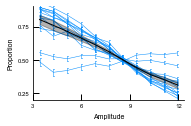

In [5]:
plt.figure(figsize=(2.7,1.8))
max_diff_amp = []
amp_frequencies_subj = []

for i,(partName, datPart) in enumerate(dats.groupby(dats.partName)):
    ampChosen, _ = np.histogram(datPart.ampChosen, bins=spaceBins)
    ampNotChosen, _ = np.histogram(datPart.ampNotChosen, bins=spaceBins)
    propRadial = ampChosen / (ampChosen + ampNotChosen *1.0)
    amp_frequencies_subj.append(propRadial)
    max_diff_amp.append(np.max(propRadial)-np.min(propRadial))
    std = [np.std(np.hstack((np.ones(c), np.zeros(nc))))
       for c,nc in zip(ampChosen,ampNotChosen)]
    se = std / np.sqrt(ampChosen+ampNotChosen)
    plt.errorbar(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), propRadial,
                 color=cols[0], linewidth=0.5, yerr=se, capsize=.5, zorder=0)

amp_frequencies_subj = np.array(amp_frequencies_subj)
p = np.mean(amp_frequencies_subj, axis=0)
se = np.std(amp_frequencies_subj, axis=0) / np.sqrt(no_participants)
plt.plot(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), p, color="k", linewidth=1, zorder=5)
plt.fill_between(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), p+se, p-se, color="k", alpha=.3, zorder=10)

Y = p
X = np.linspace(2.9,12,12)
X = (np.diff(X) / 2) + X[:-1]
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

plt.xlabel('Amplitude')
plt.ylabel('Proportion')
plt.ylim(0.2, 0.9)
plt.yticks([0.25,0.5,0.75])
plt.xticks([100,200,300,400], [3,6,9,12])
simpleaxis(plt.gca())

### Difference between experiment dates

In [6]:
amp_frequencies = []
for _, datPart in dats.groupby(dats.partName):
    for _, datSplit in datPart.groupby(datPart.expDate):
        ampChosen, _ = np.histogram(datSplit.ampChosen, bins=spaceBins)
        ampNotChosen, _ = np.histogram(datSplit.ampNotChosen, bins=spaceBins)
        propRadial = ampChosen / (ampChosen + ampNotChosen *1.0)
        amp_frequencies.append(propRadial)
amp_frequencies = np.array(amp_frequencies)

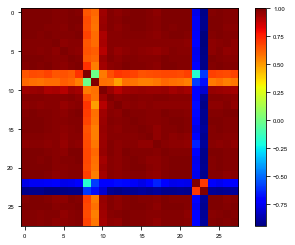

In [7]:
amp_corr_matrix = np.zeros((no_participants*2, no_participants*2))

for i in range(no_participants*2):
    for j in range(no_participants*2):
        amp_corr_matrix[i][j] = pearsonr(amp_frequencies[i], amp_frequencies[j])[0]
        
plt.imshow(amp_corr_matrix, cmap='jet')
plt.colorbar();

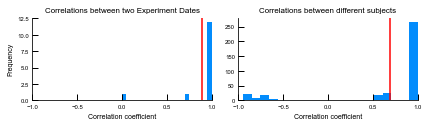

In [8]:
plt.figure(figsize=(6,1.8))

plt.subplot(121)
correlations_exp_dates = []
for i in range(0, no_participants*2, 2):
    correlations_exp_dates.append(amp_corr_matrix[i][i+1])
plt.hist(correlations_exp_dates, bins=20, color=cols[0])
plt.axvline(np.mean(correlations_exp_dates), c='r')
plt.title('Correlations between two Experiment Dates')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
plt.ylabel('Frequency')
simpleaxis(plt.gca())

plt.subplot(122)
correlations_inter_subj = []
for i in range(no_participants*2):
    for j in range(i):
        if i % 2 == 0 and i == j + 1:
            continue
        correlations_inter_subj.append(amp_corr_matrix[i][j])
plt.hist(correlations_inter_subj, bins=20, color=cols[0])
plt.axvline(np.mean(correlations_inter_subj), c='r')
plt.title('Correlations between different subjects')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
simpleaxis(plt.gca())

## Absolute Angles

Absolute Angles are the mathematical angle (counter clockwise) between the positive x-axis (1, 0) and the current point.  
The origin is at the center of the screen and the positive axis are going to the right (x) and to the top (y).

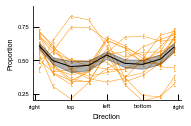

In [9]:
fig = plt.figure(figsize=(2.7,1.8))
max_diff_abs_angle = []
abs_angle_frequencies_subj = []

for partName, datPart in dats.groupby(dats.partName):
    absAnglesChosen, _ = np.histogram(datPart.angleAbsoluteChosen,
                                     bins=absAngleBins)
    absAnglesNotChosen, _ = np.histogram(datPart.angleAbsoluteNotChosen,
                                        bins=absAngleBins)
    prop_abs_angle = absAnglesChosen / (absAnglesChosen + absAnglesNotChosen)
    abs_angle_frequencies_subj.append(prop_abs_angle)
    max_diff_abs_angle.append(np.max(prop_abs_angle)-np.min(prop_abs_angle))
    std = [np.std(np.hstack((np.ones(c), np.zeros(nc))))
       for c,nc in zip(absAnglesChosen,absAnglesNotChosen)]
    se = std / np.sqrt(absAnglesChosen+absAnglesNotChosen)
    plt.errorbar(np.diff(absAngleBins) / 2 + absAngleBins[:-1], prop_abs_angle,
                 color=cols[1], linewidth=.5, yerr=se, capsize=.5, zorder=0)

abs_angle_frequencies_subj = np.array(abs_angle_frequencies_subj)
p = np.mean(abs_angle_frequencies_subj, axis=0)
se = np.std(abs_angle_frequencies_subj, axis=0) / np.sqrt(no_participants)
plt.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p, color="k", linewidth=1, zorder=5)
plt.fill_between(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p+se, p-se, color="k", alpha=.3, zorder=10)

plt.xlabel('Direction')
plt.ylabel('Proportion')
plt.xticks([0, 90, 180, 270, 360], ["right", "top", "left", "bottom", "right"])
plt.ylim(0.2, 0.9)
plt.yticks([0.25,0.5,0.75])

Y = np.arange(len(p))
X = p
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
simpleaxis(plt.gca())

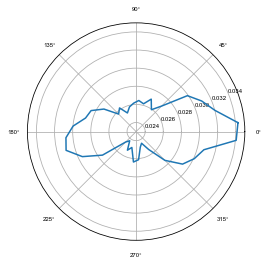

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
absAnglesChosen, _ = np.histogram(dats.angleAbsoluteChosen, bins=np.linspace(0,360,37))
absAnglesChosen = np.array(list(absAnglesChosen) + [absAnglesChosen[0]])
plt.plot(np.deg2rad(np.linspace(5,365,37)), absAnglesChosen / len(dats))
ax.set_ylim(.023, .035);

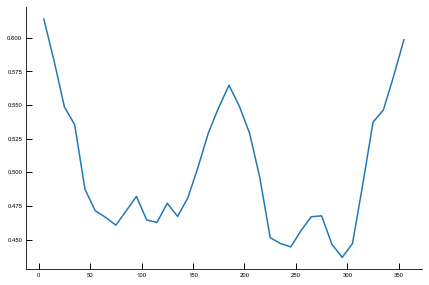

In [11]:
absAnglesChosen, _ = np.histogram(dats.angleAbsoluteChosen, bins=np.linspace(0,360,37))
absAnglesNotChosen, _ = np.histogram(dats.angleAbsoluteNotChosen, bins=np.linspace(0,360,37))
prop_abs_angle = absAnglesChosen / (absAnglesChosen + absAnglesNotChosen)
plt.plot(np.linspace(5,355,36), prop_abs_angle)
simpleaxis(plt.gca());

### Difference between experiment dates

In [12]:
abs_angle_frequencies = []
for _, datPart in dats.groupby(dats.partName):
    for _, datSplit in datPart.groupby(datPart.expDate):
        absAnglesChosen, _ = np.histogram(datSplit.angleAbsoluteChosen, bins=absAngleBins)
        absAnglesNotChosen, _ = np.histogram(datSplit.angleAbsoluteNotChosen, bins=absAngleBins)
        prop_abs_angle = absAnglesChosen / (absAnglesChosen + absAnglesNotChosen)
        abs_angle_frequencies.append(prop_abs_angle)
abs_angle_frequencies = np.array(abs_angle_frequencies)

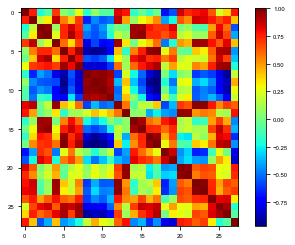

In [13]:
abs_angle_corr_matrix = np.zeros((no_participants*2, no_participants*2))

for i in range(no_participants*2):
    for j in range(no_participants*2):
        abs_angle_corr_matrix[i][j] = pearsonr(abs_angle_frequencies[i], abs_angle_frequencies[j])[0]
        
plt.imshow(abs_angle_corr_matrix, cmap='jet')
plt.colorbar();

### Difference between Subjects and between Dates

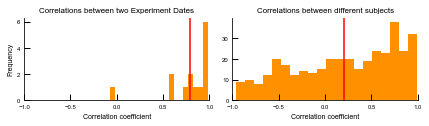

In [14]:
plt.figure(figsize=(6,1.8))

plt.subplot(121)
correlations_exp_dates = []
for i in range(0, no_participants*2, 2):
    correlations_exp_dates.append(abs_angle_corr_matrix[i][i+1])
plt.hist(correlations_exp_dates, bins=20, color=cols[1])
plt.axvline(np.mean(correlations_exp_dates), c='r')
plt.title('Correlations between two Experiment Dates')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
plt.ylabel('Frequency')
simpleaxis(plt.gca())

plt.subplot(122)
correlations_inter_subj = []
for i in range(no_participants*2):
    for j in range(i):
        if i % 2 == 0 and i == j + 1:
            continue
        correlations_inter_subj.append(abs_angle_corr_matrix[i][j])
plt.hist(correlations_inter_subj, bins=20, color=cols[1])
plt.axvline(np.mean(correlations_inter_subj), c='r')
plt.title('Correlations between different subjects')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
simpleaxis(plt.gca())

### Cluster Subjects

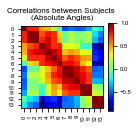

In [15]:
plt.figure(figsize=(2,1.8))

abs_angle_frequencies_vp = []
for partName, datPart in dats.groupby(dats.partName):
    relAnglesChosen, _ = np.histogram(datPart.angleAbsoluteChosen,
                                          bins=absAngleBins)
    relAnglesNotChosen, _ = np.histogram(datPart.angleAbsoluteNotChosen,
                                         bins=absAngleBins)

    freq = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
    abs_angle_frequencies_vp.append(freq)

ordered_frequencencies = [list(abs_angle_frequencies_vp[0])]
for i in range(1, len(abs_angle_frequencies_vp)):
    best_next = []
    best_next_corr = 0
    insert_pos = 0
    
    for freq in abs_angle_frequencies_vp:
        freq = list(freq)
        if freq in ordered_frequencencies:
            continue
        
        rs = pearsonr(freq, ordered_frequencencies[0])[0]
        if rs > best_next_corr:
            best_next = freq
            best_next_corr = rs
            insert_pos = 0
        re = pearsonr(freq, ordered_frequencencies[-1])[0]
        if re > best_next_corr:
            best_next = freq
            best_next_corr = re
            insert_pos = -1
    
    if insert_pos == 0:
        ordered_frequencencies.insert(0, list(best_next))
    else:
        ordered_frequencencies.append(list(best_next))

ordered_frequencencies = np.array(ordered_frequencencies)
abs_angle_corr_matrix_vp = np.zeros((no_participants, no_participants))

for i in range(no_participants):
    for j in range(no_participants):
        abs_angle_corr_matrix_vp[i][j] = pearsonr(ordered_frequencencies[i], ordered_frequencencies[j])[0]
        
plt.imshow(abs_angle_corr_matrix_vp, cmap='jet')
plt.xticks(range(no_participants), rotation=90)
plt.yticks(range(no_participants))
plt.title('Correlations between Subjects \n(Absolute Angles)')
plt.colorbar()
plt.tight_layout()

#### Hierarchical Clustering

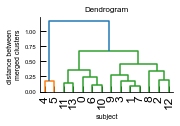

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(abs_angle_frequencies_vp, 'complete')

plt.figure(figsize=(2.5,1.8))
dendrogram(Z)
plt.xticks(rotation=90)
plt.xlabel('subject')
plt.ylabel('distance between \nmerged clusters')
plt.title('Dendrogram')
simpleaxis(plt.gca())

#### K-Means Clustering

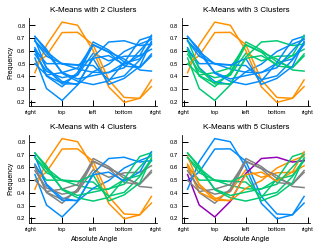

In [17]:
from sklearn.cluster import KMeans

km2 = KMeans(n_clusters=2).fit(abs_angle_frequencies_vp)
km3 = KMeans(n_clusters=3).fit(abs_angle_frequencies_vp)
km4 = KMeans(n_clusters=4).fit(abs_angle_frequencies_vp)
km5 = KMeans(n_clusters=5).fit(abs_angle_frequencies_vp)
kmeans = [km2, km3, km4, km5]

plt.figure(figsize=(4.5,3.5))
i = 0 # subplot number
for km in kmeans:
    i += 1
    plt.subplot(2,2,i)
    for label, elem in zip(km.labels_, abs_angle_frequencies_vp):
        plt.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], elem, c=cols[label])
    if i > 2:
        plt.xlabel('Absolute Angle')
    if i % 2 == 1: 
        plt.ylabel('Frequency')
    plt.xticks([0, 90, 180, 270, 360], ["right", "top", "left", "bottom", "right"])
    plt.title('K-Means with %d Clusters' % (i+1))
    simpleaxis(plt.gca())

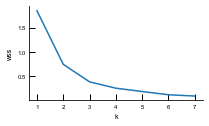

In [18]:
plt.figure(figsize=(3,1.8))
measure = "wss" # can be wss or validity
scores = []
for i in range(1,8):
    km = KMeans(n_clusters=i).fit(abs_angle_frequencies_vp)
    centroids = km.cluster_centers_
    pred_clusters = km.predict(abs_angle_frequencies_vp)
    intra = 0
    for j in range(len(abs_angle_frequencies_vp)):
        curr_center = centroids[pred_clusters[j]]
        intra += np.sum((abs_angle_frequencies_vp[j] - curr_center) ** 2)
    if measure == "wss":
        scores.append(intra)
    elif measure == "validity":
        intra /= 14
        inter = np.min([np.sum((centroids[c1,:] - centroids[c2,:]) ** 2)
                       for c1 in range(i) for c2 in range(c1)])
        scores.append(intra / inter)
            
plt.plot(range(1,8), scores)
plt.ylabel(measure)
plt.xlabel("k")
simpleaxis(plt.gca())

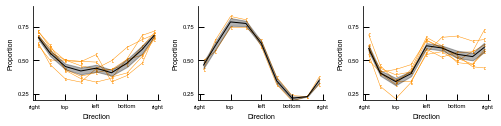

In [19]:
or_cols = ["#ffa733", "#ba6a00", "#ffc800"]
fig, axs = plt.subplots(1, 3, figsize=(7, 1.8))
for label, elem in zip(km3.labels_, abs_angle_frequencies_vp):
    axs[label].errorbar(np.diff(absAngleBins) / 2 + absAngleBins[:-1], elem,
                        c=cols[1], lw=.5, yerr=.01, capsize=.5, zorder=0)
for i,ax in enumerate(axs):
    abs_angle_frequencies_cluster = np.array(abs_angle_frequencies_subj[km3.labels_ == i])
    p = np.mean(abs_angle_frequencies_cluster, axis=0)
    se = np.std(abs_angle_frequencies_cluster, axis=0) / np.sqrt(np.sum(km3.labels_ == i))
    ax.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p, color="k", linewidth=1, zorder=5)
    ax.fill_between(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p+se, p-se, color="k", alpha=.3, zorder=10)
    ax.set_ylim(0.2, 0.9)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_xticklabels(["right", "top", "left", "bottom", "right"])
    ax.set_xlabel("Direction")
    ax.set_ylabel("Proportion")
    simpleaxis(ax)

### NHST
The first ANOVA will compare between the proportion of targets at the top, the bottom, the right and to the left. 
#### All subjects together

In [20]:
angle_boundaries = {
    "right": ((0, 45), (315, 360)),
    "top": (45, 135),
    "left": (135, 225),
    "bottom": (225, 315)
}
angle_order = {"right":0, "top":1, "left":2, "bottom":3}

In [21]:
abs_angle_props = [[] for _ in range(4)]
for partName, datPart in dats.groupby(dats.partName):
    for direction, boundaries in angle_boundaries.items():
        idx = angle_order[direction]
        if direction == "right": 
            n_chosen = len(datPart[((datPart.angleAbsoluteChosen > boundaries[0][0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[0][1])) |
                                   ((datPart.angleAbsoluteChosen > boundaries[1][0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[1][1]))])
            n_not_chosen = len(datPart[((datPart.angleAbsoluteNotChosen > boundaries[0][0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[0][1])) |
                                       ((datPart.angleAbsoluteNotChosen > boundaries[1][0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[1][1]))])
        else:
            n_chosen = len(datPart[(datPart.angleAbsoluteChosen > boundaries[0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[1])])
            n_not_chosen = len(datPart[(datPart.angleAbsoluteNotChosen > boundaries[0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[1])])
        prop_chosen = n_chosen / (n_chosen + n_not_chosen)
        abs_angle_props[idx].append(prop_chosen)

anova_res = scipy.stats.f_oneway(*abs_angle_props)
print(f"p value of ANOVA = {anova_res.pvalue}, f statistic = {anova_res.statistic}")

p value of ANOVA = 0.041374392812157226, f statistic = 2.944790585735257


#### Grouped by their k-means cluster

In [22]:
abs_angle_props_kmeans = [[[] for _ in range(4)] for _ in range(3)]
for i, (partName, datPart) in enumerate(dats.groupby(dats.partName)):
    for direction, boundaries in angle_boundaries.items():
        idx = angle_order[direction]
        if direction == "right": 
            n_chosen = len(datPart[((datPart.angleAbsoluteChosen > boundaries[0][0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[0][1])) |
                                   ((datPart.angleAbsoluteChosen > boundaries[1][0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[1][1]))])
            n_not_chosen = len(datPart[((datPart.angleAbsoluteNotChosen > boundaries[0][0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[0][1])) |
                                       ((datPart.angleAbsoluteNotChosen > boundaries[1][0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[1][1]))])
        else:
            n_chosen = len(datPart[(datPart.angleAbsoluteChosen > boundaries[0]) &
                                   (datPart.angleAbsoluteChosen <= boundaries[1])])
            n_not_chosen = len(datPart[(datPart.angleAbsoluteNotChosen > boundaries[0]) &
                                       (datPart.angleAbsoluteNotChosen <= boundaries[1])])
        prop_chosen = n_chosen / (n_chosen + n_not_chosen)
        abs_angle_props_kmeans[km3.labels_[i]][idx].append(prop_chosen)

for props in abs_angle_props_kmeans:
    anova_res = scipy.stats.f_oneway(*props)
    print(f"p value of ANOVA = {anova_res.pvalue}, f statistic = {anova_res.statistic}")

p value of ANOVA = 7.563268218363261e-06, f statistic = 17.69136077226515
p value of ANOVA = 0.0004286582528292146, f statistic = 86.62573676858817
p value of ANOVA = 6.153982392246438e-06, f statistic = 18.207377466888072


#### Horizontal vs. non-horizontal

In [23]:
dats["chosenHorizontal"] = ((dats.angleAbsoluteChosen <= 10) | 
                            (dats.angleAbsoluteChosen >= 350) |
                            ((dats.angleAbsoluteChosen >= 170) &
                             (dats.angleAbsoluteChosen <= 190)))
dats["notChosenHorizontal"] = ((dats.angleAbsoluteNotChosen <= 10) | 
                               (dats.angleAbsoluteNotChosen >= 350) |
                               ((dats.angleAbsoluteNotChosen >= 170) &
                                (dats.angleAbsoluteNotChosen <= 190)))

In [24]:
num_chosen_horizontal = np.sum(dats.chosenHorizontal)
num_not_chosen_horizontal = np.sum(dats.notChosenHorizontal)
scipy.stats.ttest_ind(np.hstack((np.ones(num_chosen_horizontal), np.zeros(len(dats)-num_chosen_horizontal))),
                      np.hstack((np.ones(num_not_chosen_horizontal), np.zeros(len(dats)-num_not_chosen_horizontal))),
                      equal_var=False)

Ttest_indResult(statistic=21.74353675261963, pvalue=1.1917167214960296e-104)

## Relative Angles

relative angles are the mathematical angles between the last sphere and the current sphere.  
180 degrees means that there is a straight line between the last sphere, the center and the current square, while 0 and 360 degrees mean that the subject went back to the same direction after going into the center

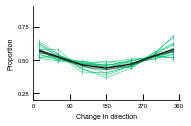

In [25]:
plt.figure(figsize=(2.7,1.8))
max_diff_rel_angle = []
rel_angle_frequencies_subj = []

for partName, datPart in dats.groupby(dats.partName):
    relAnglesChosen, _ = np.histogram(datPart.angleChosen, bins=relAngleBins)
    relAnglesNotChosen, _ = np.histogram(datPart.angleNotChosen, bins=relAngleBins)
    prop_rel_angle = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
    rel_angle_frequencies_subj.append(prop_rel_angle)
    max_diff_rel_angle.append(np.max(prop_rel_angle)-np.min(prop_rel_angle))
    std = [np.std(np.hstack((np.ones(c), np.zeros(nc))))
       for c,nc in zip(relAnglesChosen,relAnglesNotChosen)]
    se = std / np.sqrt(relAnglesChosen+relAnglesNotChosen)
    plt.errorbar(np.diff(relAngleBins) / 2 + relAngleBins[:-1], prop_rel_angle, yerr=se,
                 color=cols[2], linewidth=0.5, zorder=0)

rel_angle_frequencies_subj = np.array(rel_angle_frequencies_subj)
p = np.mean(rel_angle_frequencies_subj, axis=0)
se = np.std(rel_angle_frequencies_subj, axis=0) / np.sqrt(no_participants)
plt.plot(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p, color="k", linewidth=1, zorder=5)
plt.fill_between(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p+se, p-se, color="k", alpha=.3, zorder=10)

plt.xlabel('Change in direction')
plt.xticks([0, 90, 180, 270, 360])
plt.ylabel('Proportion')
plt.ylim(0.2, 0.9)
plt.yticks([0.25,0.5,0.75])

X = np.abs(np.diff(relAngleBins) / 2 + relAngleBins[:-1] - 180)
X = sm.add_constant(X)
Y = p

model = sm.OLS(Y, X)
results = model.fit()

#plt.title('R^2 ' + '{:.4f}'.format(results.rsquared))
simpleaxis(plt.gca())

In [26]:
relAnglesChosen, _ = np.histogram(np.abs(dats.angleChosen - 180), bins=[0,30,60,90,120,150,180])
relAnglesNotChosen, _ = np.histogram(np.abs(dats.angleNotChosen - 180), bins=[0,30,60,90,120,150,180])
X = [15,45,75,105,135,165]
X = sm.add_constant(X)
Y = relAnglesChosen + (relAnglesChosen + relAnglesNotChosen)
model = sm.OLS(Y,X)
res = model.fit()

### Difference between experiment dates

In [27]:
rel_angle_frequencies = []
for _, datPart in dats.groupby(dats.partName):
    for _, datSplit in datPart.groupby(datPart.expDate):
        relAnglesChosen, _ = np.histogram(datSplit.angleChosen, bins=relAngleBins)
        relAnglesNotChosen, _ = np.histogram(datSplit.angleNotChosen, bins=relAngleBins)
        prop_rel_angle = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
        rel_angle_frequencies.append(prop_rel_angle)
rel_angle_frequencies = np.array(rel_angle_frequencies)

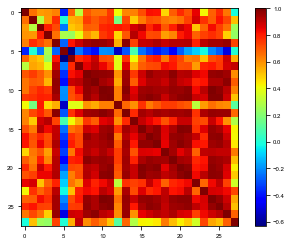

In [28]:
rel_angle_corr_matrix = np.zeros((no_participants*2, no_participants*2))

for i in range(no_participants*2):
    for j in range(no_participants*2):
        rel_angle_corr_matrix[i][j] = pearsonr(rel_angle_frequencies[i], rel_angle_frequencies[j])[0]
        
plt.imshow(rel_angle_corr_matrix, cmap='jet')
plt.colorbar();

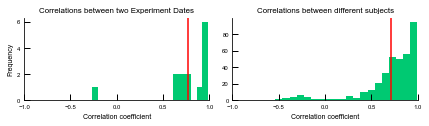

In [29]:
plt.figure(figsize=(6,1.8))

plt.subplot(121)
correlations_exp_dates = []
for i in range(0, no_participants*2, 2):
    correlations_exp_dates.append(rel_angle_corr_matrix[i][i+1])
plt.hist(correlations_exp_dates, bins=20, color=cols[2])
plt.axvline(np.mean(correlations_exp_dates), c='r')
plt.title('Correlations between two Experiment Dates')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
plt.ylabel('Frequency')
simpleaxis(plt.gca())

plt.subplot(122)
correlations_inter_subj = []
for i in range(no_participants*2):
    for j in range(i):
        if i % 2 == 0 and i == j + 1:
            continue
        correlations_inter_subj.append(rel_angle_corr_matrix[i][j])
plt.hist(correlations_inter_subj, bins=20, color=cols[2])
plt.axvline(np.mean(correlations_inter_subj), c='r')
plt.title('Correlations between different subjects')
plt.xlabel('Correlation coefficient')
plt.xlim(-1,1)
plt.xticks([-1,-.5,0,.5,1])
simpleaxis(plt.gca())

### Depending on absolute angle

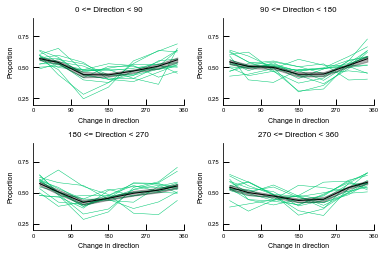

In [30]:
_, axes = plt.subplots(2, 2, figsize=(5.4,3.6))
axes = axes.flatten()
a = [0,90,180,270,360]

for i in range(4):
    rel_angle_frequencies_subj = []
    ax = axes[i]
    datAngle = dats[(dats.angleAbsoluteChosen >= a[i]) & (dats.angleAbsoluteChosen < a[i+1])]
    for partName, datPart in datAngle.groupby(datAngle.partName):
        relAnglesChosen, _ = np.histogram(datPart.angleChosen, bins=relAngleBins)
        relAnglesNotChosen, _ = np.histogram(datPart.angleNotChosen, bins=relAngleBins)
        prop_rel_angle = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
        rel_angle_frequencies_subj.append(prop_rel_angle)
        ax.plot(np.diff(relAngleBins) / 2 + relAngleBins[:-1], prop_rel_angle,
                color=cols[2], linewidth=0.5, zorder=0)

    rel_angle_frequencies_subj = np.array(rel_angle_frequencies_subj)
    p = np.mean(rel_angle_frequencies_subj, axis=0)
    se = np.std(rel_angle_frequencies_subj, axis=0) / np.sqrt(no_participants)
    ax.plot(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p, color="k", linewidth=1, zorder=5)
    ax.fill_between(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p+se, p-se, color="k", alpha=.3, zorder=10)

    ax.set_xlabel('Change in direction')
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel('Proportion')
    ax.set_ylim(0.2, 0.9)
    ax.set_yticks([0.25,0.5,0.75])
    ax.set_title(f"{a[i]} <= Direction < {a[i+1]}")
    simpleaxis(ax)

## Comparison first with all trials

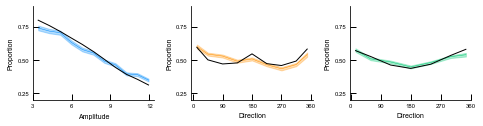

In [31]:
n = 10
first_block_df = pd.concat([dats.groupby(dats.partName).apply(
    lambda g: g[g.block_time <= np.sort(g.block_time.unique())[n-1]])]
)
fig, axes = plt.subplots(1, 3, figsize=(2.5*2.7,1.8))

ax = axes[0]
ampChosen, _ = np.histogram(first_block_df.ampChosen, bins=spaceBins)
ampNotChosen, _ = np.histogram(first_block_df.ampNotChosen, bins=spaceBins)
p = ampChosen / (ampChosen + ampNotChosen)
se = [np.std(np.hstack((np.ones(c), np.zeros(nc))))/np.sqrt(c+nc)
      for c,nc in zip(ampChosen, ampNotChosen)]
ax.plot(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), p, color=cols[0], linewidth=.5)
ax.fill_between(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), p-se, p+se, color=cols[0], alpha=.3)
ampChosen, _ = np.histogram(dats.ampChosen, bins=spaceBins)
ampNotChosen, _ = np.histogram(dats.ampNotChosen, bins=spaceBins)
p = ampChosen / (ampChosen + ampNotChosen *1.0)
ax.plot(spaceBins[:-1]+((spaceBins[1]-spaceBins[0])/2), p, color="k", linewidth=1)
ax.set_xlabel('Amplitude')
ax.set_ylabel('Proportion')
ax.set_ylim(0.2, 0.9)
ax.set_yticks([0.25,0.5,0.75])
ax.set_xticks([100,200,300,400])
ax.set_xticklabels([3,6,9,12])
simpleaxis(ax)

ax = axes[1]
absAngleChosen, _ = np.histogram(first_block_df.angleAbsoluteChosen, bins=absAngleBins)
absAngleNotChosen, _ = np.histogram(first_block_df.angleAbsoluteNotChosen, bins=absAngleBins)
p = absAngleChosen / (absAngleChosen + absAngleNotChosen)
se = [np.std(np.hstack((np.ones(c), np.zeros(nc))))/np.sqrt(c+nc)
      for c,nc in zip(absAngleChosen, absAngleChosen)]
ax.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p, color=cols[1], linewidth=.5)
ax.fill_between(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p-se, p+se, color=cols[1], alpha=.3)
absAngleChosen, _ = np.histogram(dats.angleAbsoluteChosen, bins=absAngleBins)
absAngleNotChosen, _ = np.histogram(dats.angleAbsoluteNotChosen, bins=absAngleBins)
p = absAngleChosen / (absAngleChosen + absAngleNotChosen)
ax.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], p, color="k", linewidth=1)
ax.set_xlabel('Direction')
ax.set_ylabel('Proportion')
ax.set_ylim(0.2, 0.9)
ax.set_yticks([0.25,0.5,0.75])
ax.set_xticks([0,90,180,270,360])
simpleaxis(ax)

ax = axes[2]
relAngleChosen, _ = np.histogram(first_block_df.angleChosen, bins=relAngleBins)
relAngleNotChosen, _ = np.histogram(first_block_df.angleNotChosen, bins=relAngleBins)
p = relAngleChosen / (relAngleChosen + relAngleNotChosen)
t1 = [np.hstack((np.ones(c), np.zeros(nc))) for c,nc in zip(relAngleChosen, relAngleChosen)]
se = [np.std(np.hstack((np.ones(c), np.zeros(nc))))/np.sqrt(c+nc)
      for c,nc in zip(relAngleChosen, relAngleChosen)]
ax.plot(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p, color=cols[2], linewidth=.5)
ax.fill_between(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p-se, p+se, color=cols[2], alpha=.3)
relAngleChosen, _ = np.histogram(dats.angleChosen, bins=relAngleBins)
relAngleNotChosen, _ = np.histogram(dats.angleNotChosen, bins=relAngleBins)
p = relAngleChosen / (relAngleChosen + relAngleNotChosen)
t2 = [np.hstack((np.ones(c), np.zeros(nc))) for c,nc in zip(relAngleChosen, relAngleChosen)]
ax.plot(np.diff(relAngleBins) / 2 + relAngleBins[:-1], p, color="k", linewidth=1)
ax.set_xlabel('Direction')
ax.set_ylabel('Proportion')
ax.set_ylim(0.2, 0.9)
ax.set_yticks([0.25,0.5,0.75])
ax.set_xticks([0,90,180,270,360])
simpleaxis(ax)

## Comparison different subsets
Here we calculate a MANOVA for the difference between different subsets of data. Currently you just need to comment in the correct split at the top. We can choose to compare first10 - all, first dates - second date, short cfd - long cfd

In [32]:
t = []
#for i,d in enumerate([dats,first_block_df]):
    #for _,datPart in d.groupby(d.partName):
for _,datPart in dats.groupby(dats.partName):
    #for i,(_,d) in enumerate(datPart.groupby(datPart.expDate)):
    for i,(_,d) in enumerate(datPart.groupby(datPart.short_cfd)):
        ampChosen, _ = np.histogram(d.ampChosen, bins=spaceBins)
        ampNotChosen, _ = np.histogram(d.ampNotChosen, bins=spaceBins)
        propRadial = ampChosen / (ampChosen + ampNotChosen)
        t.append([i]+list(propRadial))
manova = sm.multivariate.MANOVA.from_formula("""
    amp_0 + amp_1 + amp_2 + amp_3 + amp_4 + amp_5 + 
    amp_6 + amp_7 + amp_8 + amp_9 + amp_10 ~ split""",
    data=pd.DataFrame(t, columns=["split"]+[f"amp_{i}" for i in range(11)]))
print(manova.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept          Value     Num DF  Den DF  F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda     0.0000 11.0000 16.0000 52790.2350 0.0000
         Pillai's trace     1.0000 11.0000 16.0000 52790.2350 0.0000
 Hotelling-Lawley trace 36293.2866 11.0000 16.0000 52790.2350 0.0000
    Roy's greatest root 36293.2866 11.0000 16.0000 52790.2350 0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
            split           Value    Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------------
             Wilks' lambda  0.6346  11.0000  16.0000 

In [33]:
t = []
#for i,d in enumerate([dats,first_block_df]):
    #for _,datPart in d.groupby(d.partName):
for _,datPart in dats.groupby(dats.partName):
    #for i,(_,d) in enumerate(datPart.groupby(datPart.expDate)):
    for i,(_,d) in enumerate(datPart.groupby(datPart.short_cfd)):
        relAngleChosen, _ = np.histogram(d.angleChosen, bins=relAngleBins)
        relAngleNotChosen, _ = np.histogram(d.angleNotChosen, bins=relAngleBins)
        p = relAngleChosen / (relAngleChosen + relAngleNotChosen)
        t.append([i]+list(p))
manova = sm.multivariate.MANOVA.from_formula("""
    theta_0 + theta_1 + theta_2 + theta_3 + theta_4 +
    theta_5 + theta_6 ~ split""",
    data=pd.DataFrame(t, columns=["split"]+[f"theta_{i}" for i in range(7)]))
print(manova.mv_test())

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept           Value    Num DF  Den DF   F Value    Pr > F
----------------------------------------------------------------------
          Wilks' lambda      0.0000 7.0000 20.0000 1611878.7533 0.0000
         Pillai's trace      1.0000 7.0000 20.0000 1611878.7533 0.0000
 Hotelling-Lawley trace 564157.5636 7.0000 20.0000 1611878.7533 0.0000
    Roy's greatest root 564157.5636 7.0000 20.0000 1611878.7533 0.0000
----------------------------------------------------------------------
                                                                      
------------------------------------------------------------------------
           split            Value    Num DF    Den DF   F Value   Pr > F
------------------------------------------------------------------------
            Wilks' lamb

In [34]:
t = []
#for i,d in enumerate([dats,first_block_df]):
    #for _,datPart in d.groupby(d.partName):
for _,datPart in dats.groupby(dats.partName):
    #for i,(_,d) in enumerate(datPart.groupby(datPart.expDate)):
    for i,(_,d) in enumerate(datPart.groupby(datPart.short_cfd)):
        absAngleChosen, _ = np.histogram(d.angleAbsoluteChosen, bins=absAngleBins)
        absAngleNotChosen, _ = np.histogram(d.angleAbsoluteNotChosen, bins=absAngleBins)
        p = absAngleChosen / (absAngleChosen + absAngleNotChosen)
        t.append([i]+list(p))
manova = sm.multivariate.MANOVA.from_formula("""
    phi_0 + phi_1 + phi_2 + phi_3 + phi_4 + phi_5 +
    phi_6 + phi_7 + phi_8 ~ split""",
    data=pd.DataFrame(t, columns=["split"]+[f"phi_{i}" for i in range(9)]))
print(manova.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept          Value    Num DF  Den DF   F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda     0.0000 9.0000 18.0000 122477.9698 0.0000
         Pillai's trace     1.0000 9.0000 18.0000 122477.9698 0.0000
 Hotelling-Lawley trace 61238.9849 9.0000 18.0000 122477.9698 0.0000
    Roy's greatest root 61238.9849 9.0000 18.0000 122477.9698 0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
             split           Value   Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------------
              Wilks' lambda  0.9447  9.0000  18.0000 

## Bays & Husain (2012) JOV Plots
The two plotsa shown here are reproductions from Bays & Husain (2012) Journal of Vision, with our data.

In [35]:
dats["diffAmp"] = dats.ampChosen - dats.ampNotChosen

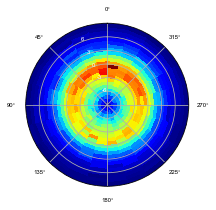

In [36]:
plt.figure(figsize=(3,3))
amp_diff = np.linspace(-300, 300, 25)
amp_diff = (amp_diff + 12.5)[:-1]
rel_angle = np.linspace(0, 360, 25)
rel_angle = np.deg2rad(rel_angle + 7.5)[:-1]
rad, angle = np.meshgrid(amp_diff, rel_angle)
z = np.zeros_like(rad)
for i in range(24):
    for j in range(24):
        ad = amp_diff[i]
        ra = np.rad2deg(rel_angle[j])
        z[j,i] = len(dats[
            (dats.diffAmp > ad - 12.5) & (dats.diffAmp <= ad + 12.5) &
            (dats.angleChosen > ra - 7.5) & (dats.angleChosen < ra + 7.5)
        ]) / len(dats)

plt.subplot(projection="polar")
plt.gca().set_theta_zero_location("N")
plt.pcolormesh(angle, rad, z, cmap='jet', shading="auto")
plt.grid()
plt.yticks([-200, -100, 0, 100, 200], [-6, -3, 0, 3, 6], color="white");

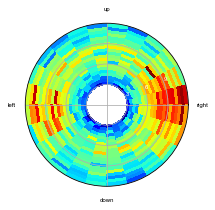

In [37]:
plt.figure(figsize=(3,3))
amp = np.linspace(100, 400, 21)
amp = (amp + 7.5)[:-1]
abs_angle = np.linspace(0, 360, 25)
abs_angle = np.deg2rad(abs_angle + 7.5)[:-1]
rad, angle = np.meshgrid(amp, abs_angle)
z = np.zeros_like(rad)
for i in range(20):
    for j in range(24):
        a = amp[i]
        aa = np.rad2deg(abs_angle[j])
        z[j,i] = len(dats[
            (dats.ampChosen > a - 7.5) & (dats.ampChosen <= a + 7.5) &
            (dats.angleAbsoluteChosen > aa - 7.5) & (dats.angleAbsoluteChosen < aa + 7.5)
        ]) / len(dats)

plt.subplot(projection="polar")
plt.gca().set_theta_zero_location("E")
plt.pcolormesh(angle, rad, z, cmap='jet', shading="auto")

plt.grid()
plt.yticks([100, 200, 300, 400], [3, 6, 9, 12], color="white")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2], ["right", "up", "left", "down"]);

## Parameter Estimation - Maximum Likelihood

In [38]:
est_log = pd.read_csv('data/model_mean_lognormal.csv', index_col=0)

In [39]:
est_log

,dist,abs_1,abs_2,abs_3,abs_4,abs_5,abs_6,rel_angle
CEM-CDC-AD0407190930,-6.991822,1.0,0.615218,0.179207,0.168345,0.692279,1.483460,0.296885
CEM-CDC-AF1202191200,-12.302217,1.0,-2.372920,0.964123,2.911791,-0.235343,1.011199,0.675680
CEM-CDC-AL1107191100,-2.980507,1.0,-0.001817,0.070310,0.778227,1.207439,1.815434,0.102885
CEM-CDC-BS0307191205,-7.128338,1.0,-0.453175,0.825724,1.708745,1.171873,2.069585,0.530516
CEM-CDC-GS2606191230,-1.280669,1.0,4.509287,3.291365,-0.431266,-2.191385,-1.309689,-0.196049
CEM-CDC-HP1311191300,-4.750235,1.0,2.670290,2.818025,0.356408,-1.648251,-1.011995,0.532394
CEM-CDC-KA2603191130,-4.289538,1.0,0.012527,0.359111,-0.325620,-0.504154,0.894782,0.666368
CEM-CDC-MA2811190930,-5.232975,1.0,0.054641,0.795021,2.181848,0.376298,1.110018,0.674832
CEM-CDC-MR1311181030,-6.663760,1.0,-1.199427,0.935038,3.691261,3.108547,3.506626,1.750178
CEM-CDC-NV1102191000,-7.149401,1.0,0.507128,1.529632,2.522387,1.373150,0.669682,1.206224


In [40]:
est_std = pd.read_csv("data/model_std_lognormal.csv", index_col=0)
est_std["abs_1"] = 0

In [41]:
import sys
sys.path.append("src/")
from MLE import Agent

In [42]:
for partName, datPart in dats.groupby(dats.partName):
    chosen_points = datPart[["ampChosen", "angleAbsoluteChosen", "angleChosen"]].values.T
    not_chosen_points = datPart[["ampNotChosen", "angleAbsoluteNotChosen", "angleNotChosen"]].values.T
    vp_est = est_log.loc[partName]
    log_agent = Agent(vp_est[0], vp_est[1:7], vp_est[7], noise_dist="lognormal")
    util_chosen = log_agent._get_value_for_points(chosen_points)
    util_not_chosen = log_agent._get_value_for_points(not_chosen_points)
    dats.loc[dats.partName == partName, "utility_chosen"] = util_chosen
    dats.loc[dats.partName == partName, "utility_not_chosen"] = util_not_chosen

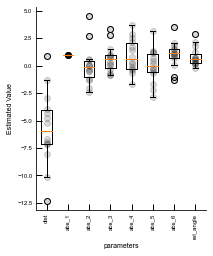

In [43]:
plt.figure(figsize=(3,3.6))
for i,c in enumerate(est_log):
    values = est_log[c].values
    plt.scatter(np.ones_like(values)*(i+1), values, c="k", alpha=0.15)
plt.boxplot(est_log)
plt.xticks(range(1,len(est_log.columns)+1), est_log.columns, rotation=90)
plt.xlabel('parameters')
plt.ylabel('Estimated Value')
simpleaxis(plt.gca())

### Radial Influence

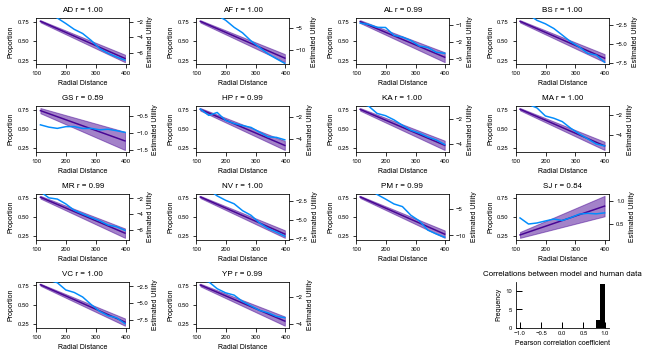

In [44]:
d_corrs = np.zeros(14)
fig, axs = plt.subplots(4, 4, figsize=(9,5))
axs = axs.flatten()
i = 0 # subplot number
for partName, datPart in dats.groupby(dats.partName):
    ax = axs[i]
    ax.set_zorder(1)
    ax.set_frame_on(False)
    vp_est = est_log.loc[partName]
    vp_std = est_std.loc[partName]
    amp_x = spaceBins[:-1] + (spaceBins[1] - spaceBins[0]) / 2
    amp_y = amp_x * vp_est["dist"]/412
    amp_y1 = amp_x/412 * (vp_est["dist"]-vp_std["amp"]*2)
    amp_y2 = amp_x/412 * (vp_est["dist"]+vp_std["amp"]*2)
    
    ampChosen, _ = np.histogram(datPart.ampChosen, bins=spaceBins)
    ampNotChosen, _ = np.histogram(datPart.ampNotChosen, bins=spaceBins)
    propRadial = ampChosen / (ampChosen + ampNotChosen *1.0)
    ax.plot(spaceBins[:-1] + (spaceBins[1] - spaceBins[0]) / 2,
            propRadial, color=cols[0], linewidth=1.5)
    d_corrs[i] = pearsonr(propRadial, amp_y)[0]
    ax.set_xlabel('Radial Distance')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0.2, 0.8)
    
    ax2 = ax.twinx()
    ax2.plot([amp_x[0], amp_x[-1]], [amp_y[0], amp_y[-1]], color='#480694', linewidth=1.5)
    ax2.fill_between([amp_x[0], amp_x[-1]], [amp_y1[0], amp_y1[-1]], [amp_y2[0], amp_y2[-1]],
                     color='#480694', alpha=.5)
    ax2.set_title(partName[8:10] + " r = %.2f"% d_corrs[i])
    ax2.set_ylabel('Estimated Utility')
    i += 1
    
fig.delaxes(axs[14])
ax = axs[-1]
ax.hist(d_corrs.flatten(), bins=np.linspace(-1,1,21), color='k')
ax.set_ylabel("Frequency")
ax.set_xlabel("Pearson correlation coefficient")
ax.set_title("Correlations between model and human data")
simpleaxis(ax)
plt.tight_layout()

### Absolute Angle

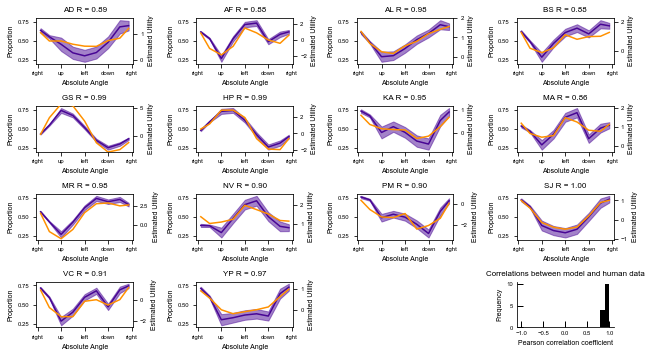

In [45]:
abs_angle_corrs = np.zeros(14)
fig, axs = plt.subplots(4, 4, figsize=(9,5))
axs = axs.flatten()
i = 0 # subplot number
for partName, datPart in dats.groupby(dats.partName):
    ax = axs[i]
    ax.set_zorder(1)
    ax.set_frame_on(False)
    ax2 = ax.twinx()
    
    vp_est = est_log.loc[partName]
    vp_std = est_std.loc[partName]
    x_abs_angle = np.diff(absAngleBins) / 2 + absAngleBins[:-1]
    y_abs_angle = np.interp(np.diff(absAngleBins) / 2 + absAngleBins[:-1],
                            [30,90,150,210,270,330], vp_est[[f"abs_{i}" for i in range(1,7)]].values,
                            period=360)
    y_abs_angle1 = np.interp(np.diff(absAngleBins) / 2 + absAngleBins[:-1],
                             [30,90,150,210,270,330],
                             vp_est[[f"abs_{i}" for i in range(1,7)]].values-\
                             vp_std[[f"abs_{i}" for i in range(1,7)]].values*2, 
                             period=360)
    y_abs_angle2 = np.interp(np.diff(absAngleBins) / 2 + absAngleBins[:-1],
                             [30,90,150,210,270,330],
                             vp_est[[f"abs_{i}" for i in range(1,7)]].values+\
                             vp_std[[f"abs_{i}" for i in range(1,7)]].values*2, 
                             period=360)
    
    ax2.plot(x_abs_angle, y_abs_angle, color='#480694', linewidth=1.5)
    ax2.fill_between(x_abs_angle, y_abs_angle1, y_abs_angle2, color='#480694', alpha=0.5)
    ax2.set_ylabel('Estimated Utility')
    
    relAnglesChosen, _ = np.histogram(datPart.angleAbsoluteChosen, bins=absAngleBins)
    relAnglesNotChosen, _ = np.histogram(datPart.angleAbsoluteNotChosen, bins=absAngleBins)
    propAngles = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
    ax.plot(np.diff(absAngleBins) / 2 + absAngleBins[:-1], propAngles,
            color=cols[1], linewidth=1.5)
    abs_angle_corrs[i] = pearsonr(propAngles, y_abs_angle)[0]
    ax.set_ylabel('Proportion')
    ax.set_xticks([0,90,180,270,360])
    ax.set_xticklabels(["right", "up", "left", "down", "right"])
    ax.set_xlabel('Absolute Angle')
    ax.set_ylim(0.2,0.8)
    ax2.set_title(partName[8:10] + " R = %.2f"% abs_angle_corrs[i])
    i += 1

fig.delaxes(axs[14])
ax = axs[-1]
ax.hist(abs_angle_corrs.flatten(), bins=np.linspace(-1,1,21), color='k')
ax.set_ylabel("Frequency")
ax.set_xlabel("Pearson correlation coefficient")
ax.set_title("Correlations between model and human data")
simpleaxis(ax)
plt.tight_layout()

### Relative Angle

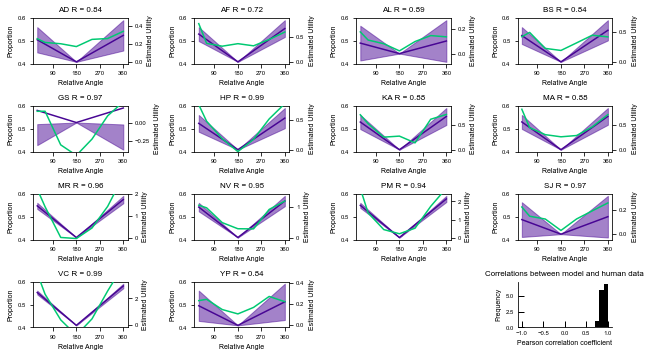

In [46]:
rel_angle_corrs = np.zeros(14)
fig, axs = plt.subplots(4, 4, figsize=(9,5))
axs = axs.flatten()
i = 0 # subplot number
for partName, datPart in dats.groupby(dats.partName):
    ax = axs[i]
    ax.set_zorder(1)
    ax.set_frame_on(False)
    
    vp_est = est_log.loc[partName]
    x_rel_angle = relAngleBins[:-1] + 30
    y_rel_angle = vp_est["rel_angle"] * (np.abs(x_rel_angle - 180) / 180)
    y_rel_angle1 = (vp_est["rel_angle"]+(vp_std["rel_angle"]*2)) * (np.abs(x_rel_angle - 180) / 180)
    y_rel_angle2 = (vp_est["rel_angle"]-(vp_std["rel_angle"]*2)) * (np.abs(x_rel_angle - 180) / 180)
    if y_rel_angle[0] < 0:
        y_rel_angle *= -1

    relAnglesChosen, _ = np.histogram(datPart.angleChosen, bins=relAngleBins)
    relAnglesNotChosen, _ = np.histogram(datPart.angleNotChosen, bins=relAngleBins)
    propAngles = relAnglesChosen / (relAnglesChosen + relAnglesNotChosen)
    ax.plot(relAngleBins[:-1]+30, propAngles, color=cols[2], linewidth=1.5)
    rel_angle_corrs[i] = pearsonr(propAngles, y_rel_angle)[0]
    
    ax.set_xlabel('Relative Angle')
    ax.set_xticks([0,90,180,270,360])
    ax.set_yticks([0.4,0.5,0.6])
    ax.set_ylabel('Proportion')
    ax.set_ylim(0.4,0.6)
    ax.set_title(partName[8:10] + ' R = %.2f'% rel_angle_corrs[i])

    ax2 = ax.twinx()
    ax2.plot(x_rel_angle, y_rel_angle, color='#480694', linewidth=1.5)
    ax2.fill_between(x_rel_angle, y_rel_angle1, y_rel_angle2, color='#480694', alpha=0.5)
    ax2.set_ylabel('Estimated Utility')
    i += 1
        
fig.delaxes(axs[14])
ax = axs[-1]
ax.hist(rel_angle_corrs.flatten(), bins=np.linspace(-1,1,21), color='k')
ax.set_ylabel("Frequency")
ax.set_xlabel("Pearson correlation coefficient")
ax.set_title("Correlations between model and human data")
simpleaxis(ax)
plt.tight_layout()

### Prediction Power

In [47]:
accuracy = dats.groupby(dats.partName).apply(lambda x: (x.utility_chosen > x.utility_not_chosen).mean()).values
np.mean(accuracy), np.std(accuracy), np.min(accuracy), np.max(accuracy)

(0.7915135027490944,
 0.050217635031969174,
 0.6889128094725512,
 0.8611474490749392)

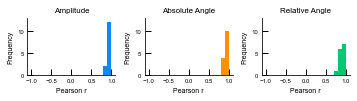

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(5,1.45))
axs = axs.flatten()
f_corrs = [d_corrs, abs_angle_corrs, rel_angle_corrs]
features = ["Amplitude", "Absolute Angle", "Relative Angle"]
for feature, corrs, ax, c in zip(features, f_corrs, axs.flatten(), cols):
    ax.hist(corrs.flatten(), bins=np.linspace(-1,1,21), color=c)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Pearson r")
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_ylim(0,13)
    ax.set_title(feature)
    simpleaxis(ax)

In [49]:
prediction_log = dats.groupby(dats.partName).apply(lambda x: np.mean(x.utility_chosen > x.utility_not_chosen)).values

In [50]:
np.mean(prediction_log), np.std(prediction_log), np.min(prediction_log), np.max(prediction_log)

(0.7915135027490944,
 0.050217635031969174,
 0.6889128094725512,
 0.8611474490749392)

In [51]:
diff_lognormal_cdf = np.loadtxt("./data/cdf_diff_lognormal_0_10_0.001")

def cdf_lognormal(values):
    idxs = np.minimum(np.abs(values) / 0.001, 10000).astype(int)
    cdf_vals = diff_lognormal_cdf[idxs]
    return np.where(values >= 0, cdf_vals, 1-cdf_vals)

In [52]:
dats["prob_chosen"] = cdf_lognormal((dats.utility_chosen - dats.utility_not_chosen).values)

In [53]:
model_certainty_perc_correct_per_subj = []
for _, datPart in dats.groupby(dats.partName):
    l = []
    for p in reversed(np.linspace(0,.5,11)[:-1]):
        num_correct = sum((datPart.prob_chosen < (1-p)) & (datPart.prob_chosen > (1-p-.05)))
        num_incorrect = sum((datPart.prob_chosen > p) & (datPart.prob_chosen < (p+.05)))
        l.append(num_correct / (num_correct + num_incorrect) if num_correct + num_incorrect != 0 else np.nan)
    model_certainty_perc_correct_per_subj.append(np.array(l))
model_certainty_perc_correct_per_subj = np.array(model_certainty_perc_correct_per_subj)

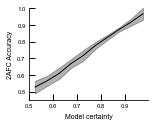

In [54]:
plt.figure(figsize=(2.2,1.8))
#for i in range(no_participants):
#    plt.plot(np.linspace(.5,.95,10)+.025, model_certainty_perc_correct_per_subj[i], c="k", alpha=0.35, lw=0.5)
m = np.nanmean(model_certainty_perc_correct_per_subj, axis=0)
sd = np.nanstd(model_certainty_perc_correct_per_subj, axis=0)
plt.plot(np.linspace(.5,.95,10)+.025, m, c="k", lw=1)
plt.fill_between(np.linspace(.5,.95,10)+.025, m-sd, m+sd, color="k", alpha=.3)
plt.xticks([.5,.6,.7,.8,.9])
plt.xlabel("Model certainty")
plt.ylabel("2AFC Accuracy")
plt.ylim(.45, 1)
simpleaxis(plt.gca())

In [55]:
dats["util_diff"] = dats.utility_chosen - dats.utility_not_chosen

In [56]:
util_diff_perc_correct_per_subj = []
for _, datPart in dats.groupby(dats.partName):
    l = []
    for u in np.linspace(0,2,11)[:-1]:
        num_correct = sum((datPart.util_diff > u) & (datPart.util_diff < (u+.2)))
        num_incorrect = sum((datPart.util_diff < -u) & (datPart.util_diff > (-u-.2)))
        l.append(num_correct / (num_correct + num_incorrect) if num_correct + num_incorrect != 0 else np.nan)
    util_diff_perc_correct_per_subj.append(np.array(l))
util_diff_perc_correct_per_subj = np.array(util_diff_perc_correct_per_subj)

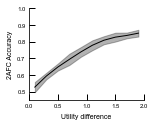

In [57]:
plt.figure(figsize=(2.2,1.8))
#for i in range(no_participants):
#    plt.plot(np.linspace(0,2,11)[:-1]+.1, util_diff_perc_correct_per_subj[i], c="k", alpha=0.35, lw=0.5)
m = np.nanmean(util_diff_perc_correct_per_subj, axis=0)
sd = np.nanstd(util_diff_perc_correct_per_subj, axis=0)
plt.plot(np.linspace(0,2,11)[:-1]+.1, m, c="k", lw=1)
plt.fill_between(np.linspace(0,2,11)[:-1]+.1, m-sd, m+sd, color="k", alpha=.3)
plt.xticks([0,0.5,1,1.5,2])
plt.xlabel("Utility difference")
plt.ylabel("2AFC Accuracy")
plt.ylim(.45, 1)
simpleaxis(plt.gca())

### iid assumption
Since noise is independent in our model it is assumed to be iid, here we employ a few checks, to see whether empirical data supports this claim.

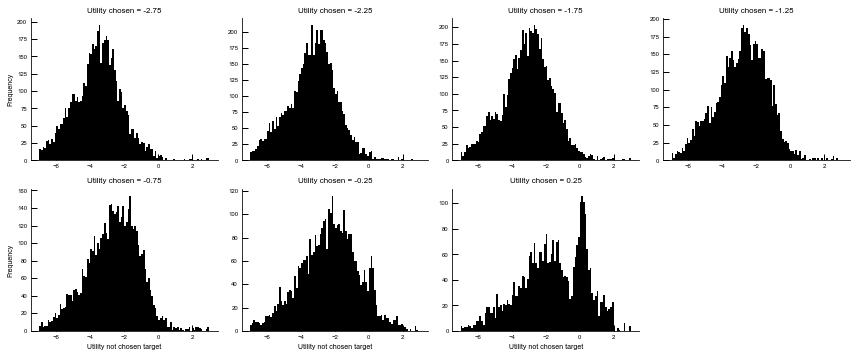

In [58]:
fig, axes = plt.subplots(2,4,figsize=(12,5))
axes = axes.flatten()
for i,u in enumerate(np.linspace(-3,0,7)):
    ax = axes[i]
    dats_util_interval = dats[(dats.utility_chosen >= u) &\
                              (dats.utility_chosen < (u+.5))]
    ax.hist(dats_util_interval.utility_not_chosen, bins=np.linspace(-7,3,101), color='k')
    ax.set_title("Utility chosen = %.2f"%(u+.25))
    simpleaxis(ax)
    if i > 3:
        ax.set_xlabel("Utility not chosen target")
    if i % 4 == 0:
        ax.set_ylabel("Frequency")
fig.delaxes(axes[-1])

In [59]:
def plot_util_utildiff(d, ax):
    max_ud = round(np.max(d.utility_chosen - d.utility_not_chosen)/2.5, 1)
    uc_left = round(np.min(d.utility_chosen+max_ud), 2)
    uc_right = round(np.max(d.utility_chosen-max_ud), 2)
    assert uc_left < uc_right
    step_size = (uc_right - uc_left) / 4
    for i,u in enumerate(np.linspace(uc_left,uc_right,5)):
        d_util_interval = d[(d.utility_chosen >= u) &\
                                          (d.utility_chosen < (u+step_size))]
        util_delta_interval = (d_util_interval.utility_chosen -\
                               d_util_interval.utility_not_chosen).values
        h, b = np.histogram(util_delta_interval, bins=np.linspace(-max_ud,max_ud,9))
        ax.plot([h[-j-1]/(h[-j-1]+h[j]) for j in reversed(range(len(h)//2))],
                c=cm(100+35*i), label="%.2f"%(u+(step_size/2)))
    ax.set_xticks(range(4))
    tl = np.linspace(0,max_ud,5)
    tl = ["%.2f"%x for x in (tl + (tl[1] / 2))[:-1]]
    ax.set_xticklabels(tl)
    ax.set_ylim(0,1)
    ax.legend()
    partName = d.partName.values[0]
    ax.set_title(partName[8:10])
    simpleaxis(ax)

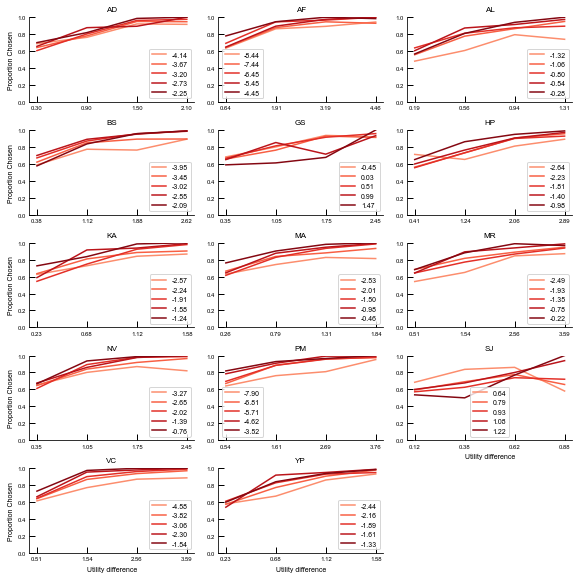

In [60]:
fig, axes = plt.subplots(5,3,figsize=(8,8))
axes = axes.flatten()
cm = plt.get_cmap("Reds")
for s,(partName, sub_dats) in enumerate(dats.groupby(dats.partName)):
    plot_util_utildiff(sub_dats, axes[s])

for i,ax in enumerate(axes):
    if i % 3 == 0:
        ax.set_ylabel("Proportion Chosen")
    if i >= 11:
        ax.set_xlabel("Utility difference")
    
fig.delaxes(axes[-1])

## Temporal Effects

In [61]:
dats["detail_additional_fixation"] = dats.detail_centfix_dur - (dats.centralFixationDuration * 250 / 60)
np.mean(dats.detail_additional_fixation / 250), np.std(dats.detail_additional_fixation / 250)

(0.255112872707369, 0.10560507798085203)

-0.08377144844627409


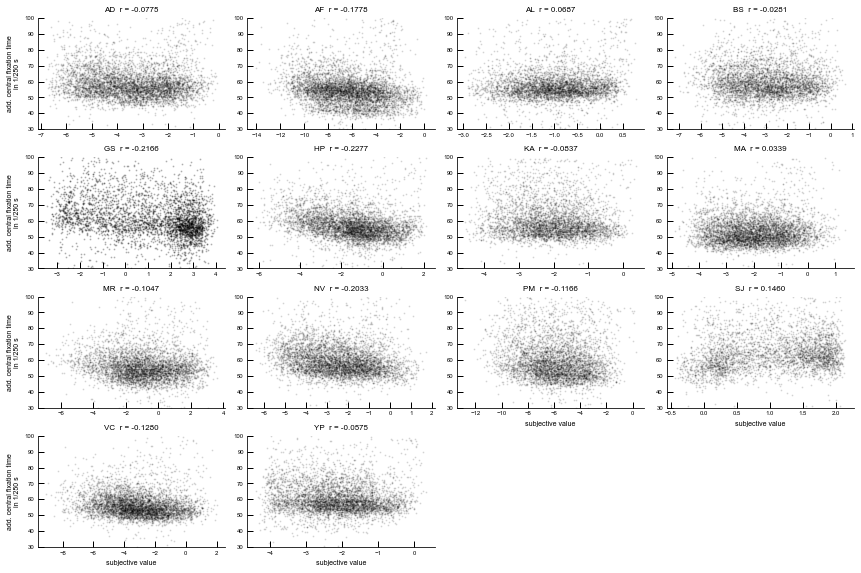

In [62]:
fig, axs = plt.subplots(4, 4, figsize=(12,8))
axs = axs.flatten()
i = 0 # subplot number
rs = []
for partName, datPart in dats.groupby(dats.partName):
    ax = axs[i]
    datPart = datPart[datPart.detail_additional_fixation <= 100]
    vs = datPart.utility_chosen.values
    r = pearsonr(datPart.detail_additional_fixation, vs)[0]
    rs.append(r)
    
    ax.scatter(vs, datPart.detail_additional_fixation, c='k', s=1, alpha=0.1)
    ax.set_title(partName[8:10] + f"  r = {r:.4f}")
    ax.set_ylim(30,100)
    if i % 4 == 0:
        ax.set_ylabel("add. central fixation time\nin 1/250 s")
    if i > 9:
        ax.set_xlabel("subjective value")
    simpleaxis(ax)
    i += 1

fig.delaxes(axs[14])
fig.delaxes(axs[15])
plt.tight_layout()
print(np.mean(rs))

-0.047079576568150885


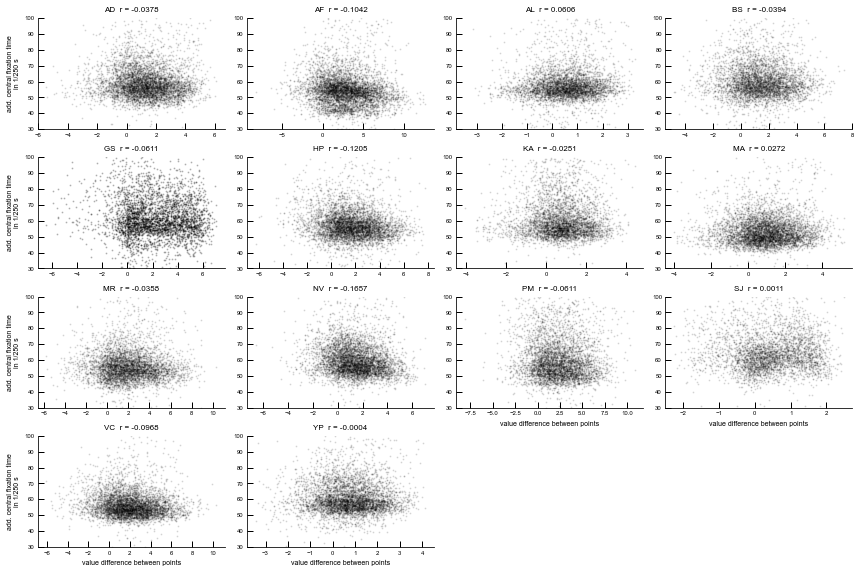

In [63]:
fig, axs = plt.subplots(4, 4, figsize=(12,8))
axs = axs.flatten()
i = 0 # subplot number
rs = []
for partName, datPart in dats.groupby(dats.partName):
    ax = axs[i]
    datPart = datPart[datPart.detail_additional_fixation <= 100]
    vs = (datPart.utility_chosen - datPart.utility_not_chosen).values
    r = pearsonr(datPart.detail_additional_fixation, vs)[0]
    rs.append(r)
    
    ax.scatter(vs, datPart.detail_additional_fixation, c='k', s=1, alpha=0.1)
    ax.set_title(partName[8:10] + f"  r = {r:.4f}")
    ax.set_ylim(30,100)
    if i % 4 == 0:
        ax.set_ylabel("add. central fixation time\nin 1/250 s")
    if i > 9:
        ax.set_xlabel("value difference between points")
    simpleaxis(ax)
    
    i += 1

fig.delaxes(axs[14])
fig.delaxes(axs[15])
plt.tight_layout()
print(np.mean(rs))

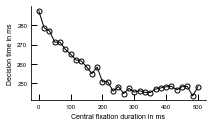

In [64]:
plt.figure(figsize=(3,1.8))
add_time_mean_forced_time = dats.groupby(dats.centralFixationDuration).detail_additional_fixation.mean()
x = add_time_mean_forced_time.index
x = x / 60 * 1000
y = add_time_mean_forced_time.values
y = y / 250 * 1000
plt.plot(x, y, "o-k", fillstyle="none", markersize=5, lw=1)
plt.xlabel("Central fixation duration in ms")
plt.ylabel("Decision time in ms")
simpleaxis(plt.gca())

In [65]:
scipy.stats.f_oneway(*[dats[dats.centralFixationDuration == i].detail_additional_fixation for i in range(15,31)])

F_onewayResult(statistic=0.5492739169291583, pvalue=0.9138158758261544)

In [66]:
np.mean(y[15:]), np.std(y[15:])

(246.7709427038808, 1.5279525480433527)

In [67]:
X = x[:15]
X = sm.add_constant(X)
Y = y[:15]
model = sm.OLS(Y,X)
res = model.fit()